In [1]:
'''

This code is part of the SIPN2 project focused on improving sub-seasonal to seasonal predictions of Arctic Sea Ice. 
If you use this code for a publication or presentation, please cite the reference in the README.md on the
main page (https://github.com/NicWayand/ESIO). 

Questions or comments should be addressed to nicway@uw.edu

Copyright (c) 2018 Nic Wayand

GNU General Public License v3.0


'''

'''
Compute the damped anomaly and add it to the climatological trend 
uses weekly aggregated obs
must have alphas computed already
must have ClimoTrend computed already
'''

%matplotlib inline
%load_ext autoreload
%autoreload
import matplotlib
import matplotlib.pyplot as plt
from collections import OrderedDict
import numpy as np
import numpy.ma as ma
import pandas as pd
import struct
import os
import xarray as xr
import glob
import datetime
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns
np.seterr(divide='ignore', invalid='ignore')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

from esio import EsioData as ed
from esio import ice_plot
from esio import import_data
from esio import metrics
import dask
import xskillscore as xs

# General plotting settings
sns.set_style('whitegrid')
sns.set_context("talk", font_scale=.8, rc={"lines.linewidth": 2.5})

In [2]:
# Damped Anomaly from Climatological Trend prediction

In [3]:
# from dask.distributed import Client
# client = Client(n_workers=2)
# client = Client()
# client
dask.config.set(scheduler='threads')  # overwrite default with threaded scheduler
# dask.config.set(scheduler='processes')  # overwrite default with threaded scheduler

In [16]:
# Parameters
cmod = 'dampedAnomalyTrend'
runType = 'forecast'

today_date = datetime.datetime.now()

pred_year =  today_date.year # Prediction year
#pred_year = 2018  # can force to do an old year
Y_Start = 1990
Y_End = 2017  # for the alpha file (okay to be a bit outdated)

E = ed.EsioData.load()
mod_dir = E.model_dir
print(pred_year)


2019


In [17]:
#############################################################
# Load in Obs Data and dink around with time variables
#############################################################

# Get obs for pred_year
obs = xr.open_mfdataset(E.obs['NSIDC_0081']['sipn_nc']+'_yearly_byweek/'+str(pred_year)+'_byweek.nc', concat_dim='time', autoclose=True, parallel=True).sic

# Get climo trend for pred_year
files_in = os.path.join(mod_dir, 'climatology', runType, 'sipn_nc_weekly', '*_week*.nc')
climo = xr.open_mfdataset(files_in, concat_dim='time', autoclose=True, parallel=True).ClimoTrendSIC
climo = climo.sel(time=slice(str(pred_year),str(pred_year+10)))
climo.name = 'sic'

past_climo = climo.isel(time=slice(0,len(obs['time'])))
# fix ugly week coordinate in obs
obs['week'].values = past_climo['week'].values

In [18]:
# compute obs anomaly of pred_year
anom = obs - past_climo

anom = anom.swap_dims({'time':'week'})
past_climo = past_climo.swap_dims({'time':'week'})

# now change the time coordinate of climo for forecasting past dec 31 conveniently
atime = np.arange(1,len(climo.time)+1)   # absolute week of time
climo.coords['abs_week'] = xr.DataArray(atime, dims='time', coords={'time':climo.time})
#climo = climo.swap_dims({'week':'fore_time'})
climo = climo.drop('week')

climo['abs_week']
climo = climo.swap_dims({'time':'abs_week'})

print(anom)
print(past_climo)
print(climo)

<xarray.DataArray 'sic' (week: 19, y: 448, x: 304)>
dask.array<shape=(19, 448, 304), dtype=float64, chunksize=(1, 448, 304)>
Coordinates:
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 295 296 297 298 299 300 301 302 303
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 439 440 441 442 443 444 445 446 447
    lat      (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
    lon      (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    xm       (x) int64 -3850000 -3825000 -3800000 ... 3675000 3700000 3725000
    ym       (y) int64 5850000 5825000 5800000 ... -5275000 -5300000 -5325000
    time     (week) datetime64[ns] 2019-01-07 2019-01-14 ... 2019-05-13
  * week     (week) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
<xarray.DataArray 'sic' (week: 19, y: 448, x: 304)>
dask.array<shape=(19, 448, 304), dtype=float64, chunksize=(1, 448, 304)>
Coordinates:
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 295 296 297 298 299 300 301 302 303
  * y        (y) int64 0

In [19]:
# Load in alphas

file_in = os.path.join(mod_dir, cmod, runType, 'param_weekly', str(Y_Start)+'_'+str(Y_End)+'_Alpha.nc')
print(file_in)
alpha = xr.open_mfdataset(file_in, autoclose=True, parallel=True).alpha
alpha.load()

/home/disk/sipn/nicway/data/model/dampedAnomalyTrend/forecast/param_weekly/1990_2017_Alpha.nc


<xarray.DataArray 'alpha' (init_time: 52, fore_time: 52, y: 448, x: 304)>
array([[[[ 0., ..., nan],
         ...,
         [nan, ...,  0.]],

        ...,

        [[ 0., ..., nan],
         ...,
         [nan, ...,  0.]]],


       ...,


       [[[ 0., ..., nan],
         ...,
         [nan, ...,  0.]],

        ...,

        [[ 0., ..., nan],
         ...,
         [nan, ...,  0.]]]])
Coordinates:
  * x          (x) int64 0 1 2 3 4 5 6 7 8 ... 296 297 298 299 300 301 302 303
  * y          (y) int64 0 1 2 3 4 5 6 7 8 ... 440 441 442 443 444 445 446 447
    lat        (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
    lon        (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    xm         (x) int64 -3850000 -3825000 -3800000 ... 3675000 3700000 3725000
    ym         (y) int64 5850000 5825000 5800000 ... -5275000 -5300000 -5325000
  * fore_time  (fore_time) int64 1 2 3 4 5 6 7 8 9 ... 45 46 47 48 49 50 51 52
  * init_time  (init_time) int64 1 2 3 4

In [20]:
# function to add a new dimension to dataarray with size of the list fill_value
from collections import OrderedDict
def expand_dimensions(data, fill_value=np.nan, **new_coords):
    ordered_coord_dict = OrderedDict(new_coords)
    shape_da = xr.DataArray(
        np.zeros(list(map(len, ordered_coord_dict.values()))),
        coords=ordered_coord_dict,
        dims=ordered_coord_dict.keys())
    expanded_data = xr.broadcast(data, shape_da)[0].fillna(fill_value)
    return expanded_data

In [21]:
max_week = anom['week'].max()
anom.week.values
oceanmask = anom.isel(week=0).notnull().drop(['week','time']).load()

In [22]:
UpdateAll = False
#UpdateAll = True
tmp = None

In [23]:
# init_time is by week so Jan 1-7 is week 1 (ranges from 1 to 52)
# fore_time is relative to init_time so fore_time = 0 is week 1 Jan 1-7 and it ranges 0 to 52
for cweek in anom.week.values:
#for cweek in [26]:
    file_out = os.path.join(mod_dir, cmod, runType, 'sipn_nc_weekly', str(pred_year)+'_week'+format(cweek,'02')+'.nc')
    
    # Only calc if it doesn't exist or if last week of pred_year
    if (os.path.isfile(file_out) & (cweek<anom.week.max()) & ~UpdateAll):
        print('skipping ',file_out)
        continue
    
    c_anomaly = anom.sel(week=cweek)  # anomaly of the init time
    time_hold = c_anomaly.time # keep a copy of the init_time actual time 
    c_anomaly = c_anomaly.drop(['week','time']) # but get rid of these annoying coords for now

    # alpha has fore_time ranging from 1 to 52, note no zero which would be alpha = ones 
    c_alpha = alpha.sel(init_time=cweek).drop(['init_time']) # select the right init_time
    
#    print(c_anomaly)
#    print(c_alpha)
#    print(climo.abs_week)
    
    tmp = c_anomaly * c_alpha  # forecast without zero time always has 52 weeks
    tmp = tmp.transpose('fore_time', 'y','x') # fix order
    
    fore_climo = climo.isel(abs_week=slice(cweek-1,cweek+52))  # tryto forecast 0 to 52 weeks from init_time
    fore_climo = fore_climo.drop('time')
    maxclimoweeks =len(fore_climo.abs_week) # but limit weeks to data on hand, <= 53
    # Add fore_time
    ftime = np.arange(0,maxclimoweeks,1)
    fore_climo.coords['fore_time'] = xr.DataArray(ftime, dims='abs_week', coords={'abs_week':fore_climo.abs_week})
    fore_climo = fore_climo.swap_dims({'abs_week':'fore_time'})
    fore_climo = fore_climo.drop('abs_week')
    fore_climo.load()
#    print('fore_climo ', fore_climo)

    predict_anom = expand_dimensions(oceanmask,fore_time=np.arange(0,maxclimoweeks))
    predict_anom = predict_anom.transpose('fore_time', 'y','x')
    
    tmp = c_anomaly * c_alpha  # forecast without zero time always has 52 weeks
    tmp = tmp.transpose('fore_time', 'y','x') # fix order

    predict_anom[0,:,:] = c_anomaly.values  # predic_anom at fore_time of 0 = anomaly at init_time
    predict_anom[1:maxclimoweeks,:,:] = tmp.values[0:(maxclimoweeks-1),:,:]  # the damped anomaly now for fore_time from 0 to 52
    
#    print('predict_anom ',predict_anom)   
    
    predict = predict_anom + fore_climo
    predict.name = 'sic'
    predict.coords['init_time'] = time_hold.drop('week')    
    predict = predict.drop(['xm','ym','time'])
    # must limit to [0,1]
    predict=predict.where(predict>0,other=0).where(oceanmask)
    predict=predict.where(predict<1,other=1).where(oceanmask)

#    print(predict)

#    predict = predict.transpose('fore_time', 'y','x')

    predict = import_data.expand_to_sipn_dims(predict)
    
    predict = predict.rename({'x':'nj','y':'ni'})
#    print(predict)
                            
    predict.to_netcdf(file_out)
    print("Saved file:",file_out)

skipping  /home/disk/sipn/nicway/data/model/dampedAnomalyTrend/forecast/sipn_nc_weekly/2019_week01.nc
skipping  /home/disk/sipn/nicway/data/model/dampedAnomalyTrend/forecast/sipn_nc_weekly/2019_week02.nc
skipping  /home/disk/sipn/nicway/data/model/dampedAnomalyTrend/forecast/sipn_nc_weekly/2019_week03.nc
skipping  /home/disk/sipn/nicway/data/model/dampedAnomalyTrend/forecast/sipn_nc_weekly/2019_week04.nc
skipping  /home/disk/sipn/nicway/data/model/dampedAnomalyTrend/forecast/sipn_nc_weekly/2019_week05.nc
skipping  /home/disk/sipn/nicway/data/model/dampedAnomalyTrend/forecast/sipn_nc_weekly/2019_week06.nc
skipping  /home/disk/sipn/nicway/data/model/dampedAnomalyTrend/forecast/sipn_nc_weekly/2019_week07.nc
skipping  /home/disk/sipn/nicway/data/model/dampedAnomalyTrend/forecast/sipn_nc_weekly/2019_week08.nc
skipping  /home/disk/sipn/nicway/data/model/dampedAnomalyTrend/forecast/sipn_nc_weekly/2019_week09.nc
skipping  /home/disk/sipn/nicway/data/model/dampedAnomalyTrend/forecast/sipn_nc_we

In [24]:
# plot some stuff as sanity check
cmap_diff_2 = matplotlib.colors.LinearSegmentedColormap.from_list("", ["purple","white","green"])
cmap_diff_2.set_bad(color = 'lightgrey')
cmap_sic = matplotlib.colors.ListedColormap(sns.color_palette("Blues_r", 10))
cmap_sic.set_bad(color = 'lightgrey')

print('Init Week ',cweek)


#init_time_2 =  pd.to_datetime(it).strftime('%Y-%m-%d')
#init_time_1 =  pd.to_datetime(it_start).strftime('%Y-%m-%d')
#valid_time_2 = pd.to_datetime(it+ft).strftime('%Y-%m-%d')
#valid_time_1 = pd.to_datetime(it_start+ft).strftime('%Y-%m-%d')
#plt.suptitle('Initialization Time: '+init_time_1+' to '+init_time_2+'\n Valid Time: '+valid_time_1+' to '+valid_time_2,
#                                 fontsize=15) # +'\n Week '+week_str

#today_date = datetime.datetime.now()

init_time_str = pd.to_datetime(time_hold.time.values ).strftime('%Y-%m-%d')
print('Init Time ', init_time_str)

print(time_hold.values)
print(pd.to_datetime(time_hold.time.values))
print(datetime.timedelta(days=10))

fore_time_str = (pd.to_datetime(time_hold.time.values) + datetime.timedelta(days=10)).strftime('%Y-%m-%d')
print('Fore Time ', fore_time_str)

Init Week  19
Init Time  2019-05-13
2019-05-13T00:00:00.000000000
2019-05-13 00:00:00
10 days, 0:00:00
Fore Time  2019-05-23


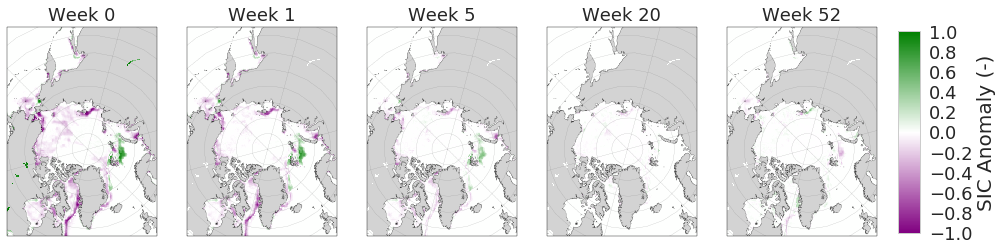

In [25]:
TestPlot = True
if TestPlot:
    c_vmin = -1
    c_vmax = 1

    c_label = 'SIC Anomaly (-)'
    ax_num=0
    p = {}

    (f, axes) = ice_plot.multi_polar_axis(ncols=5, nrows=1, Nplots = 6, sizefcter=2)
    for ftme in [0, 1, 5, 20, 52]:
        p[ax_num]=predict_anom[ftme,:,:].plot(ax=axes[ax_num], x='lon', y='lat', add_colorbar=False,vmin=c_vmin, vmax=c_vmax,
                                             transform=ccrs.PlateCarree(),cmap=cmap_diff_2)
        axes[ax_num].set_title('Week '+str(ftme), fontsize=18)
        ax_num = ax_num+1

    # Make pretty
    f.subplots_adjust(right=0.93)
    cbar_ax = f.add_axes([0.95, 0.15, 0.02, 0.7])
    if p: # if its not empty
        cbar = f.colorbar(next(iter(p.values())), cax=cbar_ax, label=c_label) # use first plot to gen colorbar
        cbar.set_ticks(np.arange(-1,1.2,0.2))
        cbar.ax.tick_params(labelsize=18) 
        cbar.set_label(label=c_label,fontsize=20)

    fig_dir = '/home/disk/sipn/nicway/data/model/dampedAnomalyTrend/forecast/sipn_nc_weekly'
    f_out = os.path.join(fig_dir,'DampedAnomaly_Init_'+str(pred_year)+'_Week'+str(cweek) +'.png')
    f.savefig(f_out,bbox_inches='tight', dpi=300)

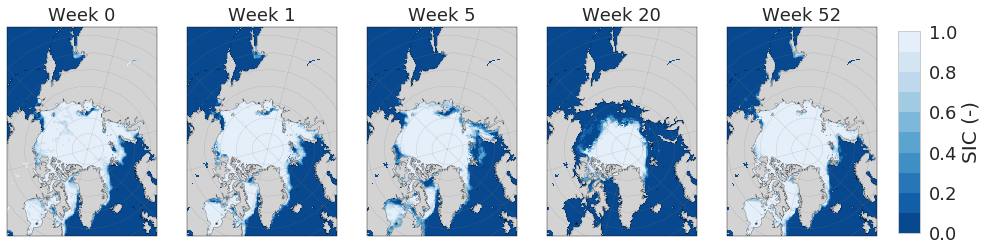

In [26]:
TestPlot = True
if TestPlot:
    
    c_label = 'SIC (-)'
    ax_num=0
    c_vmax=1
    c_vmin =0
    p = {}

    (f, axes) = ice_plot.multi_polar_axis(ncols=5, nrows=1, Nplots = 6, sizefcter=2)
    for ftme in [0, 1, 5, 20, 52]:
        p[ax_num]=predict[0,0,ftme,:,:].plot(ax=axes[ax_num], x='lon', y='lat', add_colorbar=False,vmin=c_vmin, vmax=c_vmax,
                                             transform=ccrs.PlateCarree(),cmap=cmap_sic)
        axes[ax_num].set_title('Week '+str(ftme), fontsize=18)
        ax_num = ax_num+1

    # Make pretty
    f.subplots_adjust(right=0.93)
    cbar_ax = f.add_axes([0.95, 0.15, 0.02, 0.7])
    if p: # if its not empty
        cbar = f.colorbar(next(iter(p.values())), cax=cbar_ax, label=c_label) # use first plot to gen colorbar
        cbar.set_ticks(np.arange(-1,1.2,0.2))
        cbar.ax.tick_params(labelsize=18) 
        cbar.set_label(label=c_label,fontsize=20)

    fig_dir = '/home/disk/sipn/nicway/data/model/dampedAnomalyTrend/forecast/sipn_nc_weekly'
    f_out = os.path.join(fig_dir,'DampedAnomalyTrend_Init_'+str(pred_year)+'_Week'+str(cweek) +'.png')
    f.savefig(f_out,bbox_inches='tight', dpi=300) 

In [ ]:
# Test plots for presentations from Nic

In [ ]:
test_plots = False

if test_plots:
    fig_dir = '/home/disk/sipn/nicway/Nic/figures/pres/A'

    cmap_diff_2 = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","white","blue"])
    cmap_diff_2.set_bad(color = 'lightgrey')
    cmap_sic = matplotlib.colors.ListedColormap(sns.color_palette("Blues_r", 10))
    cmap_sic.set_bad(color = 'lightgrey')

    sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

    (f, ax) = ice_plot.polar_axis()
    obs_clim_model.sel(doy=valid_doy).drop('doy').plot(ax=ax, 
                                            x='lon', y='lat', 
                                         transform=ccrs.PlateCarree(),cmap=cmap_sic,
                                                      cbar_kwargs={'label':'Sea Ice Concentration (-)'})
    plt.title('')
    f_out = os.path.join(fig_dir,'Linear_Trend.png')
    f.savefig(f_out,bbox_inches='tight', dpi=300)

    sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

    (f, ax) = ice_plot.polar_axis()
    c_anomaly.plot(ax=ax, 
                        x='lon', y='lat', 
                     transform=ccrs.PlateCarree(),cmap=cmap_diff_2,
                                  cbar_kwargs={'label':'SIC Anomaly'})
    plt.title('')
    f_out = os.path.join(fig_dir,'Anomoly.png')
    f.savefig(f_out,bbox_inches='tight', dpi=300)

    sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

    (f, ax) = ice_plot.polar_axis()
    alpha_cdoy.sel(doy=cdoy).alpha.plot(ax=ax, 
                        x='lon', y='lat', 
                     transform=ccrs.PlateCarree(),cmap=cmap_diff_2,
                                  cbar_kwargs={'label':'Lag-1 correlation'})
    plt.title('')
    f_out = os.path.join(fig_dir,'Alpha.png')
    f.savefig(f_out,bbox_inches='tight', dpi=300)



    sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

    (f, ax) = ice_plot.polar_axis()
    fore_sic.plot(ax=ax, 
                        x='lon', y='lat', 
                     transform=ccrs.PlateCarree(),cmap=cmap_sic,
                                                      cbar_kwargs={'label':'Sea Ice Concentration (-)'})
    plt.title('')
    f_out = os.path.join(fig_dir,'DampedTrend_Forecast.png')
    f.savefig(f_out,bbox_inches='tight', dpi=300)

### Compare forecasts to check they make sense